# Computing baseline Yelp business ratings for all our training data

This notebook follows guidelines in [this guide to collaborative filtering systems](http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf) to compute simple baselines for recommender system predictions.

In [1]:
%matplotlib inline
import numpy as np
import dask.bag as db
import dask.dataframe as dd
import json
import pandas as pd
import random
import os
from glob import glob
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
US_CANADA_REGION_BY_STATE_DICT = {
    'AZ': 'Phoenix',
    'NV': 'Las Vegas',
    'ON': 'Toronto',
    'NC': 'Charlotte',
    'SC': 'Charlotte',
    'OH': 'Cleveland',
    'PA': 'Pittsburgh',
    'QC': 'Montreal',
    'NY': 'Montreal',
    'VT': 'Montreal',
    'WI': 'Madison',
    'IL': 'Champaign'
}

In [3]:
# File paths
reviews_train_file = '../preprocessed-data/reviews_train.json'
all_businesses_file = '../raw-data/yelp_academic_dataset_business.json'

In [4]:
def get_businesses_df(json_file_name, us_canada_only=True):
    """ Return dataframe from raw data.
    All rows unless max_rows is set. All cities unless city is set. All columns unless select_keys is set.
    Only businesses in US/Canada if us_canada_only is true
    """
    dict_bag = db.read_text(json_file_name, blocksize=int(25e6)).map(json.loads)
    df = dict_bag.to_dataframe()
    if us_canada_only:
        df = df[df['state'].isin(US_CANADA_REGION_BY_STATE_DICT.keys())]
    df['city'] = df['state'].map(US_CANADA_REGION_BY_STATE_DICT).fillna('Non US/Canada')
    return df

In [5]:
def get_reviews_df(json_file_name, columns=None):
    """ Return dataframe from raw data.
    All rows unless max_rows is set. All cities unless city is set. All columns unless select_keys is set.
    """
    return db.read_text(json_file_name, blocksize=int(50e5)).map(json.loads).to_dataframe(columns=columns)

In [6]:
df_bus = get_businesses_df(all_businesses_file)
df_bus = df_bus[['business_id', 'city']]
df_bus.head()

,business_id,city
0,0DI8Dt2PJp07XkVvIElIcQ,Phoenix
1,LTlCaCGZE14GuaUXUGbamg,Las Vegas
2,EDqCEAGXVGCH4FJXgqtjqg,Toronto
3,cnGIivYRLxpF7tBVR_JwWA,Pittsburgh
4,cdk-qqJ71q6P7TJTww_DSA,Toronto


In [7]:
df_rev = get_reviews_df(reviews_train_file, columns=['review_id', 'business_id', 'user_id', 'stars'])
df_rev.head()

,review_id,business_id,user_id,stars
0,NxL8SIC5yqOdnlXCg18IBg,2aFiy99vNLklCx3T_tGS9A,KpkOkG6RIf4Ra25Lhhxf1A,5
1,pXbbIgOXvLuTi_SPs1hQEQ,2aFiy99vNLklCx3T_tGS9A,bQ7fQq1otn9hKX-gXRsrgA,5
2,GP6YEearUWrzPtQYSF1vVg,2LfIuF3_sX6uwe-IR-P0jQ,aW3ix1KNZAvoM8q-WghA3Q,5
3,25RlYGq2s5qShi-pn3ufVA,2LfIuF3_sX6uwe-IR-P0jQ,YOo-Cip8HqvKp_p9nEGphw,4
4,Uf1Ki1yyH_JDKhLvn2e4FQ,2LfIuF3_sX6uwe-IR-P0jQ,bgl3j8yJcRO-00NkUYsXGQ,5


In [8]:
reviews_csv_string = '../preprocessed-data/reviews-train-stars-cities/reviews-*.csv'
reviews_csv_dir = os.path.dirname(reviews_csv_string)
if len(glob(reviews_csv_string)) > 0:
    # %%time
    df_rev = dd.read_csv(reviews_csv_string)
    # 12.6 µs on my computer
else:
    # %%time
    if not os.path.isdir(reviews_csv_dir):
        os.makedirs(reviews_csv_dir)
    df_rev = df_rev.join(df_bus.set_index('business_id'), on='business_id')
    df_rev.to_csv(reviews_csv_string, index=False)
    # 4min 46s on my computer
df_rev.head()

,review_id,business_id,user_id,stars,city
0,NxL8SIC5yqOdnlXCg18IBg,2aFiy99vNLklCx3T_tGS9A,KpkOkG6RIf4Ra25Lhhxf1A,5,Phoenix
1,pXbbIgOXvLuTi_SPs1hQEQ,2aFiy99vNLklCx3T_tGS9A,bQ7fQq1otn9hKX-gXRsrgA,5,Phoenix
2,GP6YEearUWrzPtQYSF1vVg,2LfIuF3_sX6uwe-IR-P0jQ,aW3ix1KNZAvoM8q-WghA3Q,5,Phoenix
3,25RlYGq2s5qShi-pn3ufVA,2LfIuF3_sX6uwe-IR-P0jQ,YOo-Cip8HqvKp_p9nEGphw,4,Phoenix
4,Uf1Ki1yyH_JDKhLvn2e4FQ,2LfIuF3_sX6uwe-IR-P0jQ,bgl3j8yJcRO-00NkUYsXGQ,5,Phoenix


In [9]:
# %%time
# n_rev = len(df_rev)
# n_users = df_rev['user_id'].nunique().compute()
# n_bus = df_rev['business_id'].nunique().compute()

# print('Number of reviews:    {}'.format(n_rev))
# print('Number of users:      {}'.format(n_users))
# print('Number of businesses: {}'.format(n_bus))
# print('')

# Number of reviews:    3663890
# Number of users:      956530
# Number of businesses: 137048
#
# CPU times: user 3min 34s, sys: 30.9 s, total: 4min 5s
# Wall time: 5min 19s

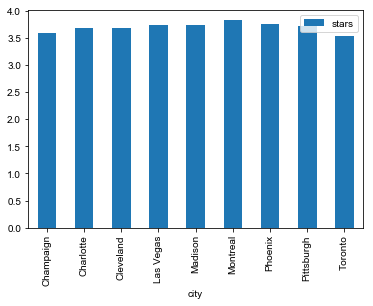

In [27]:
# df_rev[['city', 'stars']].groupby('city').mean().compute().plot(kind='bar')

Not much variation in average ratings by city. All a little above 3.5.

In [10]:
# Calculate the RMSE
def rmse(y_true, y_pred):
    diff_sq = (y_true - y_pred) ** 2
    return np.sqrt(diff_sq.mean().compute())

## Predict with the average rating of the training data

This uses the simple baseline prediction of $b_{u,i} = \mu$ as mentioned in 2.1 of the collaborative filtering guide.

In [11]:
%%time
df_train, df_test = df_rev.random_split([0.8, 0.2], random_state=0)
df_test['pred'] = df_train['stars'].mean()
error = rmse(df_test['stars'], df_test['pred'])
print('Error = {}'.format(error))

Error = 1.4093244512291574
CPU times: user 8.95 s, sys: 1.65 s, total: 10.6 s
Wall time: 8.43 s


## Predict with User's average rating

This baseline averages all of the user's ratings to give the prediction for each rating. This is $b_{u,i} = \bar{r_u}$ as mentioned in section 2.1.

In [12]:
%%time
df_train, df_test = df_rev.random_split([0.8, 0.2], random_state=0)
user_means = df_train[['user_id', 'stars']].groupby('user_id').mean().rename(columns={'stars': 'user_mean'})
train_mean = df_train['stars'].mean()
df_test = df_test.join(user_means, on='user_id').fillna(train_mean).rename(columns={'user_mean': 'pred'})
error = rmse(df_test['stars'], df_test['pred'])
print('Error = {}'.format(error))

Error = 1.4678097393829554
CPU times: user 50 s, sys: 8.09 s, total: 58.1 s
Wall time: 49.5 s


## Predict with Business's average rating

This is $b_{u,i} = \bar{r_i}$ from section 2.1.

In [13]:
%%time
df_train, df_test = df_rev.random_split([0.8, 0.2], random_state=0)
business_means = df_train[['business_id', 'stars']].groupby('business_id').mean().rename(columns={'stars': 'business_mean'})
train_mean = df_train['stars'].mean()
df_test = df_test.join(business_means, on='business_id').fillna(train_mean).rename(columns={'business_mean': 'pred'})
error = rmse(df_test['stars'], df_test['pred'])
print('Error = {}'.format(error))

Error = 1.2781815834857626
CPU times: user 29.3 s, sys: 6.04 s, total: 35.4 s
Wall time: 25.4 s


## Predict with a business and user baseline

This is equation 2.1 from section 2.1 of the collaborative filtering guide. The equation is:

$$b_{u_i} = \mu + b_u + b_i$$

where

$$b_u = \frac{1}{|I_u|}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i|}\sum_{u \in U_i} (r_{u,i} - b_u - \mu)$$

(See equations 2.2 and 2.3)

In [14]:
%%time
df_train, df_test = df_rev.random_split([0.8, 0.2], random_state=0)
# Get mean rating of all training ratings
train_mean = df_train['stars'].mean()
# Get dataframe of b_u part of baseline for each user id
df_train_user = df_train[['user_id', 'stars']].groupby('user_id').mean().rename(columns={'stars': 'user_mean'})
df_train_user['b_u'] = df_train_user['user_mean'] - train_mean
# Create column of b_u values corresponding to the user who made the review
df_train = df_train.join(df_train_user[['b_u']], on='user_id')
# Add column which will turn into b_i when averaging over each business
df_train['b_i'] = df_train['stars'] - df_train['b_u'] - train_mean
# Average over each business to get the actual b_i values for each business
df_train_bus = df_train[['business_id', 'b_i']].groupby('business_id').mean()
# Join b_u and b_i columns to test dataframe
df_test = df_test.join(df_train_user[['b_u']], on='user_id').fillna(df_train_user['b_u'].mean())
df_test = df_test.join(df_train_bus[['b_i']], on='business_id').fillna(df_train_bus['b_i'].mean())
# Predict and Compute error
df_test['pred'] = df_test['b_u'] + df_test['b_i'] + train_mean
error = rmse(df_test['stars'], df_test['pred'])
print('Error = {}'.format(error))

Error = 1.387641530621609
CPU times: user 2min 21s, sys: 20.6 s, total: 2min 42s
Wall time: 2min 22s


## Predict with a business and user baseline including damping terms

This follows the same equation 2.1 from above ($b_{u_i} = \mu + b_u + b_i$), but $b_u$ and $b_i$ are defined in a kind of Bayesian way. Specifically, damping factors are added in to push them closer to zero, making the baselines closer to the global average the lower the number of reviews. The equations for $b_u$ and $b_i$ here are

$$b_u = \frac{1}{|I_u| + \beta_u}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i| + \beta_i}\sum_{u \in U_i} (r_{u,i} - b_u - \mu)$$

(See equations 2.4 and 2.5) where $\beta_u$ and $\beta_i$ are damping factors, for which the guide reported 25 is a good number. 5 seems to work better in this case though, maybe because it's a small dataset.

In [15]:
%%time
df_train, df_test = df_rev.random_split([0.8, 0.2], random_state=0)
beta_u, beta_i = 5, 5
# Get mean rating of all training ratings
train_mean = df_train['stars'].mean()
# Get dataframe of b_u part of baseline for each user id
user_group = df_train[['user_id', 'stars']].groupby('user_id')
df_train_user = user_group.agg(['sum', 'count'])['stars']
df_train_user['b_u'] = (df_train_user['sum'] - train_mean * df_train_user['count'])
df_train_user['b_u'] /= (df_train_user['count'] + beta_u)
# Create column of b_u values corresponding to the user who made the review
df_train = df_train.join(df_train_user[['b_u']], on='user_id')
# Add column representing the expression inside the summation part of the b_i equation
df_train['b_i_sum'] = df_train['stars'] - df_train['b_u'] - train_mean
# Average over each business to get the actual b_i values for each business
bus_group = df_train[['business_id', 'b_i_sum']].groupby('business_id')
df_train_bus = bus_group.agg(['sum', 'count'])['b_i_sum'].rename(columns={'sum': 'b_i'})
df_train_bus['b_i'] /= df_train_bus['count'] + beta_i
# Join b_u and b_i columns to test dataframe
df_test = df_test.join(df_train_user[['b_u']], on='user_id').fillna(df_train_user['b_u'].mean())
df_test = df_test.join(df_train_bus[['b_i']], on='business_id').fillna(df_train_bus['b_i'].mean())
# Predict and Compute error
df_test['pred'] = df_test['b_u'] + df_test['b_i'] + train_mean
error = rmse(df_test['stars'], df_test['pred'])
print('Error = {}'.format(error))

Error = 1.2451287932974116
CPU times: user 2min 21s, sys: 20 s, total: 2min 41s
Wall time: 2min 22s
